![Enron Banner](img/Enron_banner.JPG)


## Project Description:

Enron email dataset was used to understand the nature of false positives in a proprietary software system which was capable of recognizing personally identifiable information present in email data.The proprietary system tagged emails  based on complex set of rules and regular expression matches.However, the system had lots of false positives.

They wanted to build a supervised machine learning model that can categorize emails more accurately. The major issue here was to identify  postive samples that contain PII information. Hence we devised a methodology to intelligently identify sub groups of emails based on the lingusitic information so that it can be used to extract samples(positve) which can be used to develop supervised machine learning models.

* Data Description : Meta data about each email was present in the form of raw text files along with tag information.   

* Goal: The goal of the project was to identify sub groups of email data that are probable candidates for true positives  

* Model :Word2vec is a group of related models that are used to produce word embeddings. These models are shallow, two-layer neural networks that are trained to reconstruct linguistic contexts of words. Word2vec takes as its input a large corpus of text and produces a vector space, typically of several hundred dimensions, with each unique word in the corpus being assigned a corresponding vector in the space. Word vectors are positioned in the vector space such that words that share common contexts in the corpus are located in close proximity to one another in the space [Wikipedia]  

* Results:  Five prominent Clusters of data were identified using the Word2Vec Model.

Those include

1. Government Information
2. Enron Operation
3. Legal Agreements
4. Stocks, Bonds and Traded Securities
5. People

These highlevel categories would possibly include most of the True positives in the dataset. 
  
A detailed information about how the information was processed and the words associated with these categories present in the email are desribed in this document. The set of words that comprise of these categories are listed in the results section

## Data Preprocessing

The data from raw text files were read and an Solr Index was created inorder to perform advanced text search. The following code segment describes preprocessing performed on the raw data.

In [ ]:
 import os
 import json
 import pysolr
 
 def jsonify_and_write_solr():
     """
     This function creates a json file and dumps it into solr server.
     """

     solr = pysolr.Solr('http://localhost:8983/solr/Enron_V1', timeout=10)
     solr.delete(q='*:*')
     input_solr = None
     outputs = {}
     rootdir='/home/mlguru/ml/data/'
     count = 0
     for folder, subs, files in os.walk(rootdir):
         for filename in files:
             if input_solr != None:
                 solr.add([json.loads(input_solr)])
                 input_solr = None

             with open(folder+filename,'r',encoding='UTF-16') as in_file:
                 data = {}
                 input_solr = None
                 for text_data in in_file:
                     field_par = text_data.rstrip('\n').split(":",1)
                    # print(field_par)
                     if 'category' in data:
                         data['category'].append(field_par[1])
                     else:
                         data['category']= [field_par[1]]
                     if field_par[0] == 'cont':
                         data['cont'] = field_par[1]


                 data["id"] = filename
                 if "category" not in data:
                     input_solr = None
                 else:
                     input_solr = json.dumps(data)
                 count = count + 1
                 print("[Processed: ",filename," ]")
     for key in outputs:
         print("Tag:",key,outputs[key])

 


## Extraction of PII documents from Solr Index

From the Solr Index , messages are extracted by type and stored in a python dataframe

In [153]:
import requests
import json

url = "http://localhost:8983/solr/Enron_V1/select"
params ={
    'q':'category:PII',
    'fl':'category,cont',
    'wt':'json',
    'rows':'10000'
}
resp = requests.get(url,params)
content = json.loads(resp.content.decode("utf-8"))
documents = content['response']['docs']
print "Total Documents Found",len(documents)


Total Documents Found 2797


## Data Exploration ##
PII policy had other related sub tags that came along with the policy. So We attempted to strip off PII as it is present in all the sub tags. However, most of the tags only contained "PII" and did not contain any subtags at all. The below code and chart describes the distribution of the tags.

In [154]:

tag_dict  = {'PII':0}
for element in documents:
    if len(element['category']) == 1:
        tag_dict['PII'] += 1
        continue
            
    for tag in element['category']:
        if tag != 'PII':
            if tag in tag_dict:
                tag_dict[tag] += 1
            else:
                tag_dict[tag] = 1

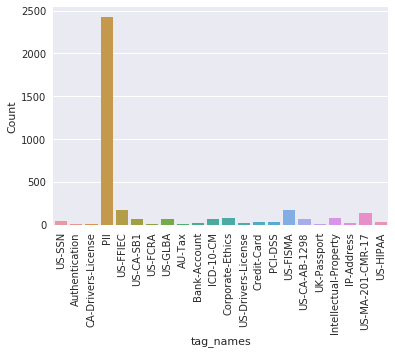

In [155]:
%matplotlib inline
import pandas as pd
import seaborn as sns
tag_df = pd.DataFrame.from_dict(tag_dict,orient="index")
tag_df['tag_names'] = tag_df.index
tag_df.columns =['Count','tag_names']
sns.set(style="darkgrid")
barplot_g= sns.barplot(x="tag_names",y="Count",data=tag_df)
for item in barplot_g.get_xticklabels():
    item.set_rotation(90)

This plot clearly shows that PII policy occured by itself in around 2400 cases. In order to clearly see other tags that occurs with PII, PII tag information was removed and the bar graph was plotted.

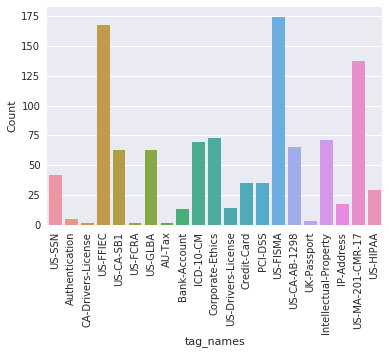

In [156]:
tag_df = tag_df.drop(['PII'])
barplot_g= sns.barplot(x="tag_names",y="Count",data=tag_df)
for item in barplot_g.get_xticklabels():
    item.set_rotation(90)

### Data Cleaning ###

The Word2Vec Model was built from the data  that contains PII tags. At the first step the email stopwords were removed from the data and was converted into sentences.

In [157]:
import nltk


def messages_to_sentences(message,tokenizer):
    # Use NLTK tokenizer to convert Words 
    raw_sentences = tokenizer.tokenize(message.strip())
    
    # Convert to Lower Case
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            lower_case_words = raw_sentence.lower().split()
            email_stopwords = ['subject:',"cc:",
                               'bcc:',"-----original message-----",
                               "from:","to:","re:","am","pm"]
            words = [w for w in lower_case_words if not w in email_stopwords]
            sentences.append(words)
            
    return sentences
            


In [158]:
sentences = []

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

for document in documents:
    if 'cont' in document:
        sentences += messages_to_sentences(document['cont'],tokenizer)
    #print(sentences)


### Exploring Document and Sentence ### 

Exploring of documents and sentences can be explored  by   
*  documents[1]   
*  sentences[5]   

The fololwing is one instance of false positive obtained from the enron dataset.

In [285]:
documents[1]

{u'category': [u'PII'],
 u'cont': u'BTW = By the way. Putnam in Boston. it\'s official. Vince -----Original Message----- From: Joseph T Pokalsky <energy.vertical@juno.com>@ENRON [mailto:IMCEANOTES-Joseph+20T+20Pokalsky+20+3Cenergy+2Evertical+40juno+2Ecom+3E+40ENRON@ENRON.com] Sent: Wednesday, June 20, 2001 12:10 PM To: Kaminski, Vince J Subject: Re: Catch Up Thanks. What does BTW mean? I assume "between the wall and us", I\'ll keep it quite. Where is he going? On Wed, 20 Jun 2001 11:02:22 -0500 Vince.J.Kaminski@enron.com writes: > Joe, > > Here it is > > david_cox@enron.net > karen.owens@enron.com > > Gail ,evidently left Enron. Haven\'t seen her in ages. > > > BTW, P. Bibi resigned. > > Vince > > -----Original Message----- > From: Joseph T Pokalsky <energy.vertical@juno.com>@ENRON > > [mailto:IMCEANOTES-Joseph+20T+20Pokalsky+20+3Cenergy+2Evertical+40juno+2E com+3E+40ENRON@ENRON.com] > > > Sent: Wednesday, June 20, 2001 7:34 AM > To: Kaminski, Vince J > Subject: Re: Catch Up > > Too ba

In [168]:
sentences[1] 

[u"it's", u"gareth's", u'deal.']

In [171]:
# creates nice output messages
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)
# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 400   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

In [172]:
from gensim.models import word2vec
print("Training Model")

model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)


model.init_sims(replace=True)



2017-08-09 20:59:37,248 : INFO : collecting all words and their counts
2017-08-09 20:59:37,253 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-08-09 20:59:37,425 : INFO : PROGRESS: at sentence #10000, processed 300183 words, keeping 35086 word types


Training Model


2017-08-09 20:59:37,549 : INFO : PROGRESS: at sentence #20000, processed 516099 words, keeping 51436 word types
2017-08-09 20:59:37,727 : INFO : PROGRESS: at sentence #30000, processed 753990 words, keeping 63595 word types
2017-08-09 20:59:37,954 : INFO : PROGRESS: at sentence #40000, processed 989035 words, keeping 74024 word types
2017-08-09 20:59:38,111 : INFO : PROGRESS: at sentence #50000, processed 1244035 words, keeping 81682 word types
2017-08-09 20:59:38,293 : INFO : PROGRESS: at sentence #60000, processed 1486494 words, keeping 91310 word types
2017-08-09 20:59:38,556 : INFO : PROGRESS: at sentence #70000, processed 1717779 words, keeping 96406 word types
2017-08-09 20:59:38,749 : INFO : PROGRESS: at sentence #80000, processed 2000703 words, keeping 109772 word types
2017-08-09 20:59:39,006 : INFO : PROGRESS: at sentence #90000, processed 2240408 words, keeping 113271 word types
2017-08-09 20:59:39,218 : INFO : PROGRESS: at sentence #100000, processed 2476609 words, keeping 

## Model Checking ##

A simple verification is made to understand about how the system has learned from the data. Since Enron extensively dealth with power, we wanted to verify how well the model deciphers the context of the emails

In [173]:
model.most_similar("power")

[(u'electricity', 0.6878064274787903),
 (u'utilities', 0.6165686845779419),
 (u'supply', 0.6113274097442627),
 (u'demand', 0.5968204140663147),
 (u'rates', 0.5378960371017456),
 (u'utility', 0.5223536491394043),
 (u"california's", 0.495941162109375),
 (u'plants', 0.485878050327301),
 (u'energy', 0.4827885031700134),
 (u'costs', 0.4771900475025177)]

We could see that power is related with Electricity, utilities ,supply and demand. It seems appropriate for the particular context.

# Clustering of Words to identify patterns in the dataset #

We attempted to cluster documents.The only information clustering uses is the similarity between examples.Clustering groups examples based of their mutual similarities

A good clustering is one that achieves:

1. High within-cluster similarity
2. Low inter-cluster similarity. 

We chose to evalluate various clustering models and evaluate them. We chose three clustering models to evaluated them based on silhouette metric.

### Choosing the Value of K

We created multiple models with various clustering sizes and evaluated the model for various values of K.

## Perform K Means Clustering

In [236]:
from sklearn.metrics import silhouette_score


cluster_sizes = [100,200,250,270,300,320,340,375,400,420,440,
                 460,480,490,500,520,540]
word_vectors = model.wv.syn0

s = []
for n_clusters in cluster_sizes:
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(word_vectors)

    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    s.append(silhouette_score(word_vectors, labels, metric='euclidean'))



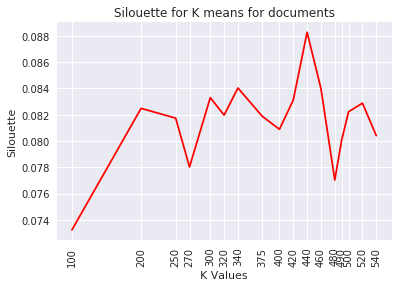

Best Value of K is 440
Best value of Silhouette score is  0.0882703


In [237]:
import pylab as plt
plt.title("Silouette for K means for documents")
plt.xlabel("K Values")
plt.ylabel("Silouette")
plt.plot(cluster_sizes,s, 'r')
plt.xticks(cluster_sizes, cluster_sizes, rotation='vertical')
plt.show()
print "Best Value of K is",cluster_sizes[s.index(max(s))]
print "Best value of Silhouette score is ", max(s)

## Perform Agglomerative Clustering


The AgglomerativeClustering object performs a hierarchical clustering using a bottom up approach: each observation starts in its own cluster, and clusters are successively merged together[ Scikit Learn Documentation]. We used Ward linkage strategy.

 Ward clustering stWard minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach. 

In [242]:
from sklearn.cluster import AgglomerativeClustering

cluster_sizes = [100,200,250,270,300,320,340,375,400,420,440,460,480,490,500,520,540]
word_vectors = model.wv.syn0

s = []
for n_clusters in cluster_sizes:
    ward = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')\
            .fit(word_vectors)

    labels = ward.labels_
    s.append(silhouette_score(word_vectors, labels, metric='euclidean'))


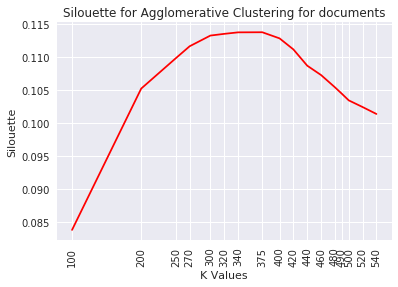

Best Value of K is 375
Best value of Silhouette score is  0.113715


In [243]:
import pylab as plt
plt.title("Silouette for Agglomerative Clustering for documents")
plt.xlabel("K Values")
plt.ylabel("Silouette")
plt.plot(cluster_sizes,s, 'r')
plt.xticks(cluster_sizes, cluster_sizes, rotation='vertical')
plt.show()
print "Best Value of K is",cluster_sizes[s.index(max(s))]
print "Best value of Silhouette score is ", max(s)

## Perform DBScan ##

In [268]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics

db = DBSCAN(eps=0.9, min_samples=10).fit(word_vectors)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(word_vectors, labels))

print "Total Number of Clusters " ,n_clusters_

Silhouette Coefficient: 0.010
Total Number of Clusters  4


### Interpretation of silhouette  Values and Choosing the value of K ###

We attempted to choose the optimal number of clusters for our exploration. The choice of K was done using Silouette coefficient. A Silhouette value describes a measure of how close each point in one cluster is to points in the neighboring clusters 

Silhouette index (overall average silhouette) a larger Silhouette value indicates a better quality of a clustering result [Chen et al. 2002]

Below table explains about the structural integrity of the silhouette number. 


|Range of SC | Interpretation                   |
|------------|----------------------------------|
|   0.71-1.0 | A strong structure has been found|
|   0.51-0.70 |A reasonable structure has been found|
|   0.26-0.50 | The structure is weak and could be artificial|
| less than 0.25 | No substantial structure has been found|


### Comparision of Various Clustering Algorithms


|Algorithm | Number of Clusters                 |   Best Silhoutte value |
|------------|----------------------------------|------------------------|
| Hierarchical Clustering | 375|0.113715|
| K Means | 440| 0.0882703 |
| DB Scan | 4| 0.010|


From the above table, it could be concluded that hierarchical clustering performed the best. However, the documents did not have a substantial structure. We would examine these 375 Clusters to see how various documents are structured.

### Clustering of Words to identify Patterns in the dataset

We chose hierarchical clustering with 375 Clusters as it gave us the Best silhoutte value. The source code below shows how the model was built

In [271]:
from sklearn.cluster import AgglomerativeClustering
import time

start = time.time() # Start time

# Set "k" (num_clusters) to be 1/5th of the vocabulary size, or an
# average of 5 words per cluster
word_vectors = model.wv.syn0
num_clusters = 375

# Initalize a k-means object and use it to extract centroids
ward = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')\
        .fit(word_vectors)
#Compute cluster centers and predict cluster index for each sample.
idx = ward.fit_predict( word_vectors )

# Get the end time and print how long the process took
end = time.time()
elapsed = end - start
print "Time taken for Agglomerative clustering: ", elapsed, "seconds."

Time taken for Agglomerative clustering:  0.623178005219 seconds.


In [272]:
# Create a Word / Index dictionary, mapping each vocabulary word to
# a cluster number                                                                                            
word_centroid_map = dict(zip( model.wv.index2word, idx ))

In [279]:
# Exploration of few clusters
for cluster in xrange(53,58):
    #
    # Print the cluster number  
    print "\nCluster %d" % cluster
    #
    # Find all of the words for that cluster number, and print them out
    words = []
    for i in xrange(0,len(word_centroid_map.values())):
        if( word_centroid_map.values()[i] == cluster ):
            words.append(word_centroid_map.keys()[i])
    print words


Cluster 53
[u'iso', u'agency', u'ferc']

Cluster 54
[u'system', u'transmission']

Cluster 55
[u'documents', u'kay']

Cluster 56
[u'assistant', u'secretary']

Cluster 57
[u'chief', u'andrew', u'former', u'officer']


# Results

From examining various clusters, it has been determined that there are five discrete clusters of information. The following are the groups and the related set of key words that would be related with True positives.

*Government* : 

* Cluster 6 :[u'bill', u'senate', u'house']
* Cluster 319 :[u'regulatory', u'federal']
* Cluster 90 :[u'u.s.', u'government']


Enron Operation:

* Cluster 31 :[u'systems', u'management', u'technology', u'marketing']
* Cluster 54 :[u'system', u'transmission']
* Cluster 75 :[u'plants', u'generators', u'costs']
* Cluster 81 :[u'rates', u'pay', u'cut']
* Cluster 121: [u'electricity', u'power']  
* Cluster 50: [u'plant', u'generation']
* Cluster 350: [u'industry']
* Cluster 351: [u'houston']
* Cluster 352 :[u'support']
* Cluster 353 :[u'sales']
* Cluster 219: [u'crisis', u"california's"]
* Cluster 89: [u'international', u'account']

 Legal Agreements :

* Cluster 22: [u'agreement.', u'section', u'language', u'form']
* Cluster 125: [u'general', u'attorney', u'counsel']
* Cluster 229: [u'legally', u'otherwise']
* Cluster 58:[u'evidence', u',s']
* Cluster 173 :[u'opinion', u'text', u'summary']
* Cluster 178:[u'contracts', u'long-term']

Stocks, Bonds and Traded Securities:

* Cluster 193: [u'shares', u'stock']
* Cluster 72 [u'exchange', u'commission', u'securities']
* Cluster 66 [u'employees', u'options']
* Cluster 68: [u"company's", u'investors', u"enron's"]
* Cluster 46: [u'rating', u'bonds', u'bond', u'debt']
* Cluster 257 :[u'sell', u'buy']
* Cluster 126: [u'rate', u'increase']

*People :*

* Cluster 71: [u'paul', u'peter']
* Cluster 373 :[u'steve', u'jim', u'tom', u'john', u'mike', u'chris']

# Conclusion and Recommendation:

From the above results, it can be concluded that these five categories and the list of keywords would more likely be associated with true positive values and can be used for filtering out true positives. Careful examination of the output for these categories are required so that true positive emails can be extracted from this data. Once these emails are obtained, we can then create a superivsed model that can detect PII with much greater acccuracy.

